In [ ]:
"""
Analyze the results from the validation testing

"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path
import neuron_visualizations as nviz


import datajoint_utils as du
from importlib import reload

INFO - 2020-11-30 18:15:58,003 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2020-11-30 18:15:58,005 - settings - Setting database.user to celiib
INFO - 2020-11-30 18:15:58,006 - settings - Setting database.password to newceliipass
INFO - 2020-11-30 18:15:58,011 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2020-11-30 18:15:58,012 - settings - Setting enable_python_native_blobs to True
INFO - 2020-11-30 18:15:58,025 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2020-11-30 18:15:58,284 - settings - Setting enable_python_native_blobs to True


In [2]:
import time
import datajoint_utils as du
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

from datajoint_utils import *

import error_detection as ed

minnie,schema = du.configure_minnie_vm()

INFO - 2020-11-30 18:15:58,312 - settings - Setting enable_python_native_blobs to True
INFO - 2020-11-30 18:15:58,573 - settings - Setting enable_python_native_blobs to True


# Results stored in the table

In [3]:
minnie.ValidationStats()

segment_id segment id for those to be decimated,new_segment_id,true_positive_presyn,false_positive_presyn,true_negative_presyn,false_negative_presyn,precision_presyn,recall_presyn,f1_presyn,true_positive_postsyn,false_positive_postsyn,true_negative_postsyn,false_negative_postsyn,precision_postsyn,recall_postsyn,f1_postsyn,true_positive_total,false_positive_total,true_negative_total,false_negative_total,precision_total,recall_total,f1_total
864691134988386682,864691135278269857,35,0,19,244,1.0,0.12544802867383512,0.22292993630573246,0,0,1862,14,nan,0.0,nan,35,0,1881,258,1.0,0.11945392491467577,0.21341463414634146
864691135113167769,864691135367058169,78,2,22,105,0.975,0.4262295081967213,0.5931558935361216,5,156,2085,9,0.031055900621118012,0.35714285714285715,0.05714285714285714,83,158,2107,114,0.34439834024896265,0.4213197969543147,0.3789954337899544
864691135212632448,864691135446675028,254,2,27,130,0.9921875,0.6614583333333334,0.7937500000000001,7,9,3336,7,0.4375,0.5,0.4666666666666667,261,11,3363,137,0.9595588235294118,0.6557788944723618,0.7791044776119402
864691135212690816,864691135775906989,0,0,16,31,nan,0.0,nan,0,0,2334,2,nan,0.0,nan,0,0,2350,33,nan,0.0,nan
864691135233108569,864691136023889209,0,0,12,47,nan,0.0,nan,0,0,731,2,nan,0.0,nan,0,0,743,49,nan,0.0,nan
864691135272164113,864691136194298600,61,0,20,133,1.0,0.31443298969072164,0.4784313725490196,0,11,5636,18,0.0,0.0,nan,61,11,5656,151,0.8472222222222222,0.28773584905660377,0.4295774647887324
864691135348272855,864691136143561524,342,0,12,97,1.0,0.7790432801822323,0.8758002560819462,4,31,5967,21,0.11428571428571428,0.16,0.13333333333333333,346,31,5979,118,0.9177718832891246,0.7456896551724138,0.8228299643281808
864691135382947307,864691135593659947,13,0,50,20,1.0,0.3939393939393939,0.5652173913043478,1,34,2599,0,0.02857142857142857,1.0,0.05555555555555556,14,34,2649,20,0.2916666666666667,0.4117647058823529,0.34146341463414637
864691135393964789,864691137019596142,133,0,14,68,1.0,0.6616915422885572,0.7964071856287425,11,0,1592,96,1.0,0.102803738317757,0.1864406779661017,144,0,1606,164,1.0,0.4675324675324675,0.6371681415929203
864691135407289801,864691135848030814,184,0,9,84,1.0,0.6865671641791045,0.8141592920353982,4,203,3124,3,0.01932367149758454,0.5714285714285714,0.037383177570093455,188,203,3133,87,0.48081841432225064,0.6836363636363636,0.5645645645645645


# Computing the Stats

In [5]:
import statistics_utils as st_u

In [6]:
TP,FP,FN = minnie.ValidationStats.fetch("true_positive_total","false_positive_total","false_negative_total")
total_dict = dict(type="presyn and postsyn")
total_stats = st_u.calculate_scores(TP = np.sum(TP),FP = np.sum(FP),FN = np.sum(FN))
total_dict.update(total_stats)
total_dict

{'type': 'presyn and postsyn',
 'precision': 0.5451688923802043,
 'recall': 0.32177299703264095,
 'f1': 0.40468832001866}

In [7]:
TP_pre,FP_pre,FN_pre = minnie.ValidationStats.fetch("true_positive_presyn","false_positive_presyn","false_negative_presyn")
presyn_dict = dict(type="presyn")
presyn_stats = st_u.calculate_scores(TP = np.sum(TP_pre),FP = np.sum(FP_pre),FN = np.sum(FN_pre))
presyn_dict.update(presyn_stats)
presyn_dict

{'type': 'presyn',
 'precision': 0.9759907434191496,
 'recall': 0.3643628509719222,
 'f1': 0.5306282928363608}

In [8]:
TP_post,FP_post,FN_post = minnie.ValidationStats.fetch("true_positive_postsyn","false_positive_postsyn","false_negative_postsyn")
postsyn_dict = dict(type="postsyn")
postsyn_stats = st_u.calculate_scores(TP = np.sum(TP_post),FP = np.sum(FP_post),FN = np.sum(FN_post))
postsyn_dict.update(postsyn_stats)
postsyn_dict

{'type': 'postsyn',
 'precision': 0.033012379642365884,
 'recall': 0.06299212598425197,
 'f1': 0.04332129963898916}

# Putting the Results in a Nice Table

In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame()

In [11]:
new_dic = df.append([presyn_dict,postsyn_dict,total_dict],ignore_index=True)
new_dic

,type,precision,recall,f1
0,presyn,0.975991,0.364363,0.530628
1,postsyn,0.033012,0.062992,0.043321
2,presyn and postsyn,0.545169,0.321773,0.404688


In [12]:
filtered_columns  = new_dic[["precision","recall","f1"]]#
accuracies = filtered_columns.to_numpy()
accuracies

array([[0.97599074, 0.36436285, 0.53062829],
       [0.03301238, 0.06299213, 0.0433213 ],
       [0.54516889, 0.321773  , 0.40468832]])

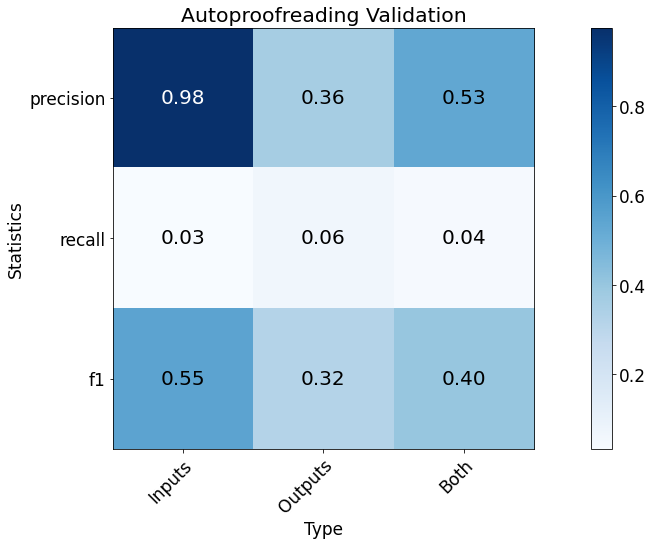

In [13]:
import matplotlib.pyplot as plt
import matplotlib

#setting the text size
matplotlib.rcParams.update({'font.size': 17})


cm = accuracies
normalize = True
cmap=plt.cm.Blues
#now graph the results for all the categories
title = "Autoproofreading Validation"

fig, ax = plt.subplots()
im = ax.imshow(accuracies, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(accuracies.shape[1]),
       yticks=np.arange(accuracies.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=["Inputs","Outputs","Both"], yticklabels=["precision","recall","f1"],
       title=title,
       ylabel='Statistics',
       xlabel='Type')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = np.nanmax(cm) / 2.
thresh = 0.6
#print("threshold = " + str(thresh))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        #print("cm[i,j] = " + str(cm[i,j]))
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
               fontsize=20)
fig.tight_layout()

fig.set_size_inches(20, 12)
ax.grid(False)

# Computing the Precision and Recall for everyone

In [92]:
minnie.ValidationStats()

segment_id segment id for those to be decimated,new_segment_id,true_positive_presyn,false_positive_presyn,true_negative_presyn,false_negative_presyn,precision_presyn,recall_presyn,f1_presyn,true_positive_postsyn,false_positive_postsyn,true_negative_postsyn,false_negative_postsyn,precision_postsyn,recall_postsyn,f1_postsyn,true_positive_total,false_positive_total,true_negative_total,false_negative_total,precision_total,recall_total,f1_total
864691134988386682,864691135278269857,35,0,19,244,1.0,0.12544802867383512,0.22292993630573246,0,0,1862,14,nan,0.0,nan,35,0,1881,258,1.0,0.11945392491467577,0.21341463414634146
864691135113167769,864691135367058169,78,2,22,105,0.975,0.4262295081967213,0.5931558935361216,5,156,2085,9,0.031055900621118012,0.35714285714285715,0.05714285714285714,83,158,2107,114,0.34439834024896265,0.4213197969543147,0.3789954337899544
864691135212632448,864691135446675028,254,2,27,130,0.9921875,0.6614583333333334,0.7937500000000001,7,9,3336,7,0.4375,0.5,0.4666666666666667,261,11,3363,137,0.9595588235294118,0.6557788944723618,0.7791044776119402
864691135212690816,864691135775906989,0,0,16,31,nan,0.0,nan,0,0,2334,2,nan,0.0,nan,0,0,2350,33,nan,0.0,nan
864691135233108569,864691136023889209,0,0,12,47,nan,0.0,nan,0,0,731,2,nan,0.0,nan,0,0,743,49,nan,0.0,nan
864691135272164113,864691136194298600,61,0,20,133,1.0,0.31443298969072164,0.4784313725490196,0,11,5636,18,0.0,0.0,nan,61,11,5656,151,0.8472222222222222,0.28773584905660377,0.4295774647887324
864691135348272855,864691136143561524,342,0,12,97,1.0,0.7790432801822323,0.8758002560819462,4,31,5967,21,0.11428571428571428,0.16,0.13333333333333333,346,31,5979,118,0.9177718832891246,0.7456896551724138,0.8228299643281808
864691135382947307,864691135593659947,13,0,50,20,1.0,0.3939393939393939,0.5652173913043478,1,34,2599,0,0.02857142857142857,1.0,0.05555555555555556,14,34,2649,20,0.2916666666666667,0.4117647058823529,0.34146341463414637
864691135393964789,864691137019596142,133,0,14,68,1.0,0.6616915422885572,0.7964071856287425,11,0,1592,96,1.0,0.102803738317757,0.1864406779661017,144,0,1606,164,1.0,0.4675324675324675,0.6371681415929203
864691135407289801,864691135848030814,184,0,9,84,1.0,0.6865671641791045,0.8141592920353982,4,203,3124,3,0.01932367149758454,0.5714285714285714,0.037383177570093455,188,203,3133,87,0.48081841432225064,0.6836363636363636,0.5645645645645645


In [29]:
filtered_table = (minnie.ValidationStats() & "recall_presyn > 0" & "recall_postsyn > 0" & "recall_total > 0")
filtered_table

segment_id segment id for those to be decimated,new_segment_id,true_positive_presyn,false_positive_presyn,true_negative_presyn,false_negative_presyn,precision_presyn,recall_presyn,f1_presyn,true_positive_postsyn,false_positive_postsyn,true_negative_postsyn,false_negative_postsyn,precision_postsyn,recall_postsyn,f1_postsyn,true_positive_total,false_positive_total,true_negative_total,false_negative_total,precision_total,recall_total,f1_total
864691135113167769,864691135367058169,78,2,22,105,0.975,0.4262295081967213,0.5931558935361216,5,156,2085,9,0.031055900621118012,0.35714285714285715,0.05714285714285714,83,158,2107,114,0.34439834024896265,0.4213197969543147,0.3789954337899544
864691135212632448,864691135446675028,254,2,27,130,0.9921875,0.6614583333333334,0.7937500000000001,7,9,3336,7,0.4375,0.5,0.4666666666666667,261,11,3363,137,0.9595588235294118,0.6557788944723618,0.7791044776119402
864691135348272855,864691136143561524,342,0,12,97,1.0,0.7790432801822323,0.8758002560819462,4,31,5967,21,0.11428571428571428,0.16,0.13333333333333333,346,31,5979,118,0.9177718832891246,0.7456896551724138,0.8228299643281808
864691135382947307,864691135593659947,13,0,50,20,1.0,0.3939393939393939,0.5652173913043478,1,34,2599,0,0.02857142857142857,1.0,0.05555555555555556,14,34,2649,20,0.2916666666666667,0.4117647058823529,0.34146341463414637
864691135393964789,864691137019596142,133,0,14,68,1.0,0.6616915422885572,0.7964071856287425,11,0,1592,96,1.0,0.102803738317757,0.1864406779661017,144,0,1606,164,1.0,0.4675324675324675,0.6371681415929203
864691135407289801,864691135848030814,184,0,9,84,1.0,0.6865671641791045,0.8141592920353982,4,203,3124,3,0.01932367149758454,0.5714285714285714,0.037383177570093455,188,203,3133,87,0.48081841432225064,0.6836363636363636,0.5645645645645645
864691135491233631,864691136378815445,67,1,14,84,0.9852941176470589,0.44370860927152317,0.6118721461187214,1,73,679,4,0.013513513513513514,0.2,0.02531645569620253,68,74,693,88,0.4788732394366197,0.4358974358974359,0.45637583892617445
864691135589906955,864691135337845734,171,3,42,175,0.9827586206896551,0.49421965317919075,0.6576923076923077,9,156,5669,21,0.05454545454545454,0.3,0.0923076923076923,180,159,5711,196,0.5309734513274337,0.4787234042553192,0.5034965034965035
864691135589907979,864691135122442535,198,0,14,309,1.0,0.3905325443786982,0.5617021276595745,6,27,3855,25,0.18181818181818182,0.1935483870967742,0.18750000000000003,204,27,3869,334,0.8831168831168831,0.379182156133829,0.5305591677503251
864691135699269154,864691135117960925,16,1,26,142,0.9411764705882353,0.10126582278481013,0.18285714285714286,1,26,4535,36,0.037037037037037035,0.02702702702702703,0.03125,17,27,4561,178,0.38636363636363635,0.08717948717948718,0.14225941422594143


In [15]:
"""
Pseudocode: 
1) Get the precision and recall for all of the neurons 
2) Filter away those that are Nan
3) Plot the precision and recall distribution
4) Get the median precision and recall
"""

'\nPseudocode: \n1) Get the precision and recall for all of the neurons \n2) Filter away those that are Nan\n3) Plot the precision and recall distribution\n4) Get the median precision and recall\n'

In [32]:
#1) Get the precision and recall for all of the neurons 
(precision_presyn,precision_postsyn,precision_total,
 recall_presyn,recall_postsyn,recall_total) = filtered_table.fetch("precision_presyn","precision_postsyn","precision_total",
                                                                  "recall_presyn","recall_postsyn","recall_total")

In [34]:
precision_dicts = [dict(stat="precision",inputs=pre,ouptuts=post,both=b) for pre,post,b in zip(precision_presyn,precision_postsyn,precision_total)]
recall_dicts = [dict(stat="recall",inputs=pre,ouptuts=post,both=b) for pre,post,b in zip(recall_presyn,recall_postsyn,recall_total)]
total_dicts=  precision_dicts + recall_dicts

In [40]:
input_info = [precision_presyn,recall_presyn]
output_info = [precision_postsyn,recall_postsyn]
both_info = [precision_total,recall_total]
total_info = [input_info,output_info,both_info]

info_name = ["input","output","both"]

revised_dicts= []
for i_name,(prec,rec) in zip(info_name,total_info):
    for p,r in zip(prec,rec):
        revised_dicts.append({"Type":i_name,"Precision":p,"Recall":r})
revised_dicts

[{'Type': 'input', 'Precision': 0.975, 'Recall': 0.4262295081967213},
 {'Type': 'input', 'Precision': 0.9921875, 'Recall': 0.6614583333333334},
 {'Type': 'input', 'Precision': 1.0, 'Recall': 0.7790432801822323},
 {'Type': 'input', 'Precision': 1.0, 'Recall': 0.3939393939393939},
 {'Type': 'input', 'Precision': 1.0, 'Recall': 0.6616915422885572},
 {'Type': 'input', 'Precision': 1.0, 'Recall': 0.6865671641791045},
 {'Type': 'input',
  'Precision': 0.9852941176470589,
  'Recall': 0.44370860927152317},
 {'Type': 'input',
  'Precision': 0.9827586206896551,
  'Recall': 0.49421965317919075},
 {'Type': 'input', 'Precision': 1.0, 'Recall': 0.3905325443786982},
 {'Type': 'input',
  'Precision': 0.9411764705882353,
  'Recall': 0.10126582278481013},
 {'Type': 'input',
  'Precision': 0.9868421052631579,
  'Recall': 0.436046511627907},
 {'Type': 'input', 'Precision': 1.0, 'Recall': 0.4720496894409938},
 {'Type': 'input',
  'Precision': 0.967741935483871,
  'Recall': 0.36585365853658536},
 {'Type': '

# Plotting the Precisions

In [41]:
import seaborn as sns
import pandas as pd

# create a dataframe to pass to it

In [42]:
df = pd.DataFrame()
new_dict = df.append(revised_dicts)
new_dict

,Type,Precision,Recall
0,input,0.975000,0.426230
1,input,0.992188,0.661458
2,input,1.000000,0.779043
3,input,1.000000,0.393939
4,input,1.000000,0.661692
...,...,...,...
85,both,0.944444,0.269366
86,both,0.923767,0.907489
87,both,0.255556,0.560976
88,both,0.835714,0.524664


<Figure size 1440x1440 with 0 Axes>

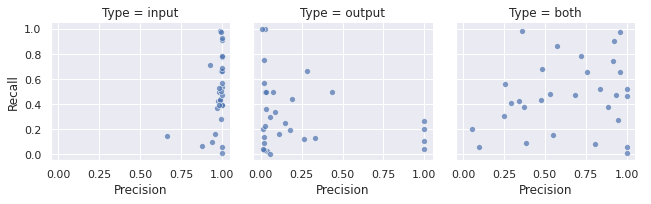

In [55]:
plt.figure(figsize=(20,20))
sns.set(rc={'figure.figsize':(20,8.27)})

g = sns.FacetGrid(new_dict, col="Type")
g.map(sns.scatterplot, "Precision", "Recall", alpha=.7)
g.add_legend()

plt.show()

In [58]:
collapsed_df = new_dict.groupby("Type").median()

In [61]:
reordered_medians = collapsed_df.iloc[[1,2,0]]
median_accuracies = reordered_medians.to_numpy()
median_accuracies.T

array([[0.99306954, 0.05505051, 0.70256917],
       [0.48313467, 0.23611111, 0.46826758]])

In [63]:
median_accuracies.T

array([[0.99306954, 0.05505051, 0.70256917],
       [0.48313467, 0.23611111, 0.46826758]])

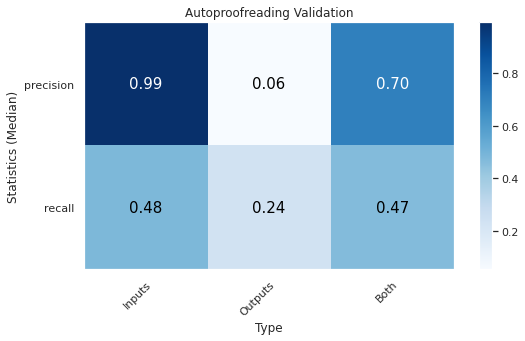

In [85]:
import matplotlib.pyplot as plt
import matplotlib

#setting the text size


accuracies = median_accuracies.T
cm = accuracies
normalize = True
cmap=plt.cm.Blues
#now graph the results for all the categories
title = "Autoproofreading Validation"

fig, ax = plt.subplots()
im = ax.imshow(accuracies, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(accuracies.shape[1]),
       yticks=np.arange(accuracies.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=["Inputs","Outputs","Both"], yticklabels=["precision","recall"],
       title=title,
       ylabel='Statistics (Median)',
       xlabel='Type')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = np.nanmax(cm) / 2.
thresh = 0.6
#print("threshold = " + str(thresh))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        #print("cm[i,j] = " + str(cm[i,j]))
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
               fontsize=15)
fig.tight_layout()
plt.rcParams.update({'font.size': 2})
fig.set_size_inches(7, 4)
ax.grid(False)

# Histogram of Per Neuron what we are removing

In [87]:
n_errored_synapses = (minnie.AutoProofreadLabels & "n_synapses>0").fetch("n_errored_synapses")

In [90]:
np.max(n_errored_synapses)

10251

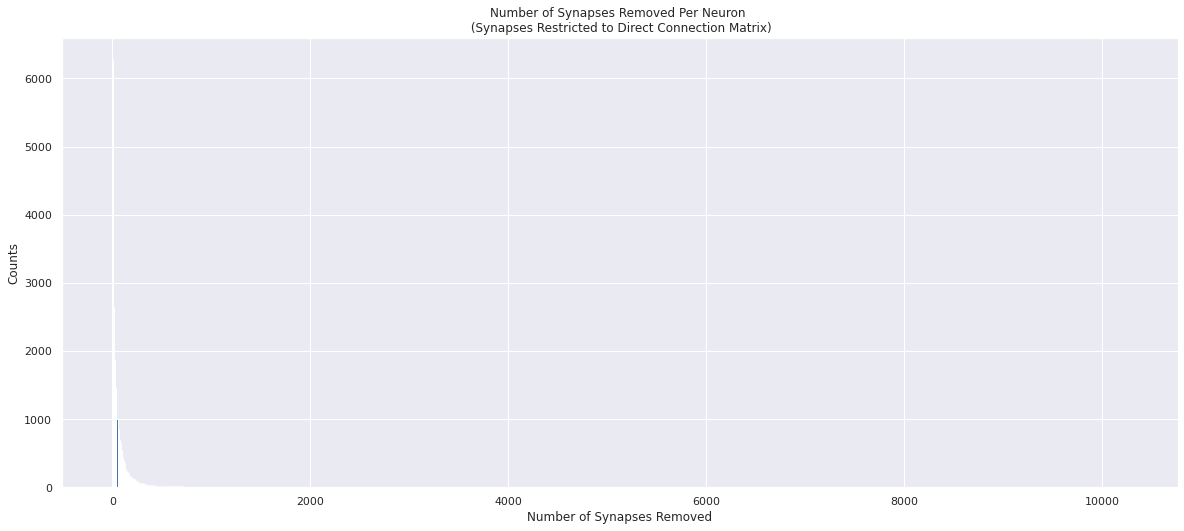

In [91]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.hist(n_errored_synapses,bins=1000,density=False)
ax.set_title("Number of Synapses Removed Per Neuron \n (Synapses Restricted to Direct Connection Matrix)")
ax.set_xlabel("Number of Synapses Removed")
ax.set_ylabel("Counts")

# ax.set_yscale("log")
#ax.set_xscale("log")
plt.show()